python3  
Create Date: 2023-04-05  
Author: Scc_hy  
Func: Learning Rate Scheduling  
Reference: https://d2l.ai/chapter_optimization/lr-scheduler.html  
===============================================================================


# 加载包

In [1]:
import math
from tqdm.auto import tqdm
import torch
from torch import nn
from torch.optim import lr_scheduler
from torchvision import transforms
import torchvision
from argparse import Namespace
from IPython import display
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline
import wandb
import os
import numpy as np
import random
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# 重要函数

## 记录训练log 及 随机种子

In [2]:
class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        """Defined in :numref:`sec_utils`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


# 设置全局的随机种子
def all_seed(seed = 6666):
    """
    设置随机种子
    """
    np.random.seed(seed)
    random.seed(seed)
    # CPU
    torch.manual_seed(seed) 
    # GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed) 
    # python 全局
    os.environ['PYTHONHASHSEED'] = str(seed) 
    # cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    print(f'Set env random_seed = {seed}')

    
all_seed(2023)

Set env random_seed = 2023


## 绘制损失图

In [3]:
def use_svg_display():
    """Use the svg format to display a plot in Jupyter.
    Defined in :numref:`sec_calculus`"""
    backend_inline.set_matplotlib_formats('svg')


def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib.
    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
    axes.set_xscale(xscale), axes.set_yscale(yscale)
    axes.set_xlim(xlim),     axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
    

class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_utils`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y, clear_flag=True):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        if clear_flag:
            display.clear_output(wait=True)


## 加载数据与网络

In [4]:
def gpu(i=0):
    """获取GPU设备"""
    return torch.device(f'cuda:{i}')


def num_gpus():
    """获取GPU个数"""
    return torch.cuda.device_count()


def try_gpu(i=0):
    """
    尝试并获取第i个GPU
    """
    if num_gpus() >= i + 1:
        return gpu(i)
    return torch.device('cpu')


def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory.
    Defined in :numref:`sec_utils`"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="./data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="./data", train=False, transform=trans, download=True)
    return (torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=4),
            torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=4))


def net_fn():
    model = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
        nn.Linear(120, 84), nn.ReLU(),
        nn.Linear(84, 10))

    return model

##  训练测试评估

In [5]:
def accuracy(y_hat, y):
    """Compute the number of correct predictions.
    Defined in :numref:`sec_utils`"""
    argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
    astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)
    reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = argmax(y_hat, axis=1)
    cmp = astype(y_hat, y.dtype) == y
    return float(reduce_sum(astype(cmp, y.dtype)))


def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU.
    Defined in :numref:`sec_utils`"""
    size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), size(y))
    return metric[0] / metric[1]


def train(model, train_iter, test_iter, config, scheduler=None):
    device = config.device
    loss = config.loss
    opt = config.opt
    num_epochs = config.num_epochs
    model.to(device)
    animator = Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    
    ep_total_steps = len(train_iter)
    for ep in range(num_epochs):
        tq_bar = tqdm(enumerate(train_iter))
        tq_bar.set_description(f'[ Epoch {ep+1}/{num_epochs} ]')
        # train_loss, train_acc, num_examples
        metric = Accumulator(3)
        for idx, (X, y) in tq_bar:
            final_flag = (ep_total_steps == idx + 1) & (num_epochs == ep + 1)
            model.train()
            opt.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            l = loss(y_hat, y)
            l.backward()
            opt.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            tq_bar.set_postfix({
                "loss" : f"{train_loss:.3f}",
                "acc" : f"{train_acc:.3f}",
            })
            if (idx + 1) % 50 == 0:
                animator.add(ep + idx / len(train_iter), (train_loss, train_acc, None), clear_flag=not final_flag)

        test_acc = evaluate_accuracy_gpu(model, test_iter)
        animator.add(ep+1, (None, None, test_acc), clear_flag=not final_flag)
        if scheduler:
            if scheduler.__module__ == lr_scheduler.__name__:
                # 使用 PyTorch In-Built scheduler
                scheduler.step()
            else:
                # 使用自定义 scheduler
                for param_group in opt.param_groups:
                    param_group['lr'] = scheduler(ep) 

    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    plt.show()


def test(train_iter, test_iter, scheduler=None):
    net = net_fn()
    cfg = Namespace(
        device=try_gpu(),
        loss=nn.CrossEntropyLoss(),
        lr=0.3, 
        num_epochs=10,
        opt=torch.optim.SGD(net.parameters(), lr=0.3)
    )
    train(net, train_iter, test_iter, cfg, scheduler)


# 可视化网络

In [12]:
# 可视化网络
from torch import onnx
import netron

d = torch.rand(1, 1, 28, 28)
m = net_fn()
o = m(d)
print(o)
onnx_path = "tmp.onnx"
onnx.export(m, d, onnx_path)
netron.start(onnx_path)

tensor([[ 0.0144, -0.0174,  0.0073,  0.0854,  0.0385,  0.0430, -0.0826, -0.1383,
         -0.1272,  0.1016]], grad_fn=<AddmmBackward0>)
============== Diagnostic Run torch.onnx.export version 2.0.0+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Serving 'tmp.onnx' at http://localhost:8080


('localhost', 8080)

In [16]:
netron.stop()

Stopping http://localhost:8080


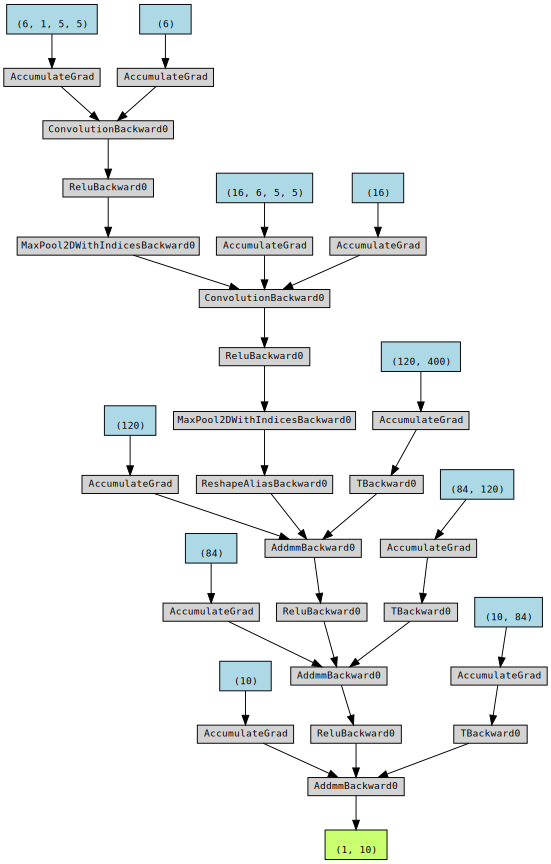

In [19]:
from torchviz import make_dot
g = make_dot(o)
g

# 数据加载

In [6]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size=batch_size)

# 学习率时间表试验

In [9]:
def get_lr(scheduler):
    lr = scheduler.get_last_lr()[0]
    scheduler.optimizer.step()
    scheduler.step()
    return lr

def plot_scheduler(scheduler, num_epochs=10):
    s = scheduler.__class__.__name__
    if scheduler.__module__ == lr_scheduler.__name__:
        print('pytorch build lr_scheduler')
        plot_y = [get_lr(scheduler) for _ in range(num_epochs)]
    else:
        plot_y = [scheduler(t) for t in range(num_epochs)]

    plt.title(f'train with learning rate scheduler: {s}')
    plt.plot(torch.arange(num_epochs), plot_y)
    plt.xlabel('num_epochs')
    plt.ylabel('learning_rate')
    plt.show()


## 1- 无时间表试验

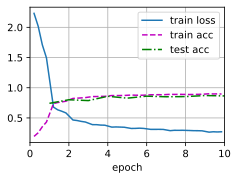

train loss 0.273, train acc 0.895, test acc 0.864


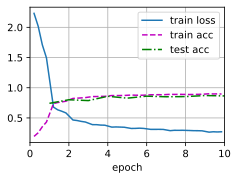

In [8]:
test(train_iter, test_iter)

## 2- SquareRootScheduler

更新公式：
$$\alpha =\alpha*\sqrt{num\_update + 1}$$

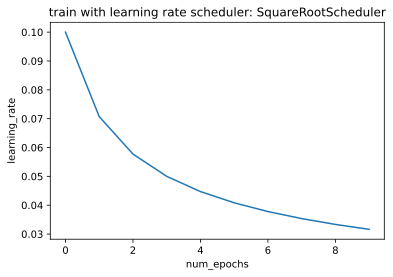

In [9]:
class SquareRootScheduler:
    """
    使用均方根scheduler
    每一个epoch更新一次
    """
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.5)

scheduler = SquareRootScheduler(lr=0.1)
plot_scheduler(scheduler)

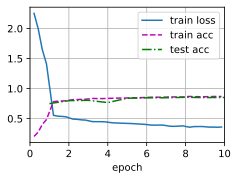

train loss 0.362, train acc 0.868, test acc 0.853


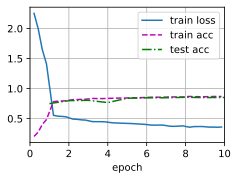

In [10]:
test(train_iter, test_iter, scheduler)

## 3- FactorScheduler

$\eta_{t+1} \leftarrow \mathop{\mathrm{max}}(\eta_{\mathrm{min}}, \eta_t \cdot \alpha)$

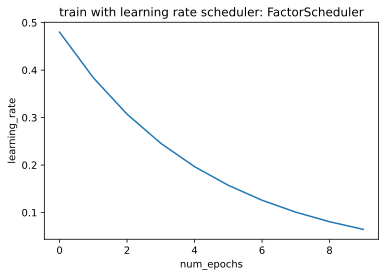

In [11]:
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.1):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self, num_update):
        self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr

scheduler = FactorScheduler(factor=0.8, stop_factor_lr=1e-2, base_lr=0.6)
plot_scheduler(scheduler)

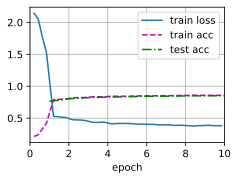

train loss 0.380, train acc 0.860, test acc 0.853


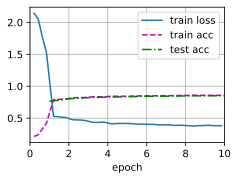

In [12]:
test(train_iter, test_iter, scheduler)

## 4- Multi Factor Scheduler

保持学习率分段恒定，并每隔一段时间将其降低一个给定的量。也就是说，给定一组何时降低速率的时间比如$ (s = \{3, 8\} )$  
$decrease (\eta_{t+1} \leftarrow \eta_t \cdot \alpha) \ \   t \in s$  

pytorch build lr_scheduler


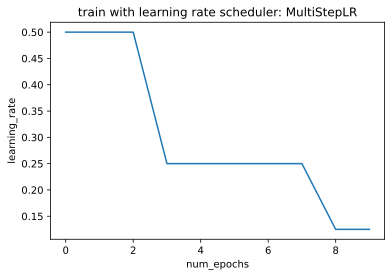

In [13]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
scheduler = lr_scheduler.MultiStepLR(trainer, milestones=[3, 8], gamma=0.5)

plot_scheduler(scheduler)

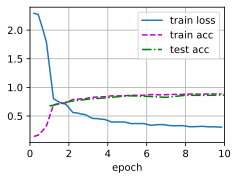

train loss 0.307, train acc 0.887, test acc 0.866


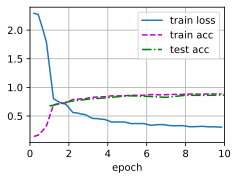

In [14]:
test(train_iter, test_iter, scheduler)

## 5- CosineScheduler

Loshchilov和Hutter提出了一个相当令人困惑的启发式方法。它依赖于这样一种观察，即我们可能<font color=darkred>不想在一开始就大幅降低学习率</font>，此外，我们<font color=darkred>可能希望在最后使用非常小的学习率</font>来“完善”解决方案。这导致了一个类似余弦的时间表，具有以下函数形式，用于范围内的学习率$t \in [0, T]$

$$\eta_t = \eta_T + \frac{\eta_0 - \eta_T}{2} \left(1 + \cos(\frac{\pi t}{T})\right)$$

注：
- $\eta_T$: 为最终的学习率
- $\eta_0$: 为最开始的学习率

In [7]:
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, step):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(step) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, step):
        if step < self.warmup_steps:
            return self.get_warmup_lr(step)
        if step <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (step - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr

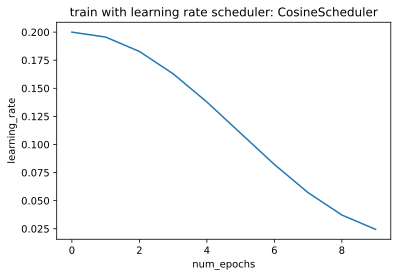

In [16]:
scheduler = CosineScheduler(max_update=10, base_lr=0.2, final_lr=0.02)
plot_scheduler(scheduler)

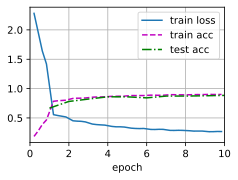

train loss 0.269, train acc 0.900, test acc 0.884


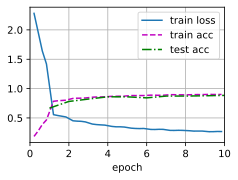

In [17]:
test(train_iter, test_iter, scheduler)

## 6- Warmup

在某些情况下，初始化参数不足以保证良好的解决方案。对于一些先进的网络设计来说，这尤其是一个问题（`Transformer的训练常用该方法`），可能会导致不稳定的优化问题。
我们可以通过选择一个足够小的学习率来解决这个问题，以防止一开始就出现分歧。不幸的是，这意味着进展缓慢。相反，学习率高最初会导致差异。

对于这种困境，一个相当简单的解决方案是使用一个预热期，在此期间学习速率增加到其初始最大值，并冷却速率直到优化过程结束。为了简单起见，通常使用线性增加来实现这一目的。

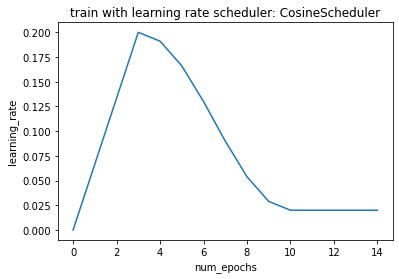

In [10]:
scheduler = CosineScheduler(max_update=10, warmup_steps=3, base_lr=0.2, final_lr=0.02)
plot_scheduler(scheduler, 15)

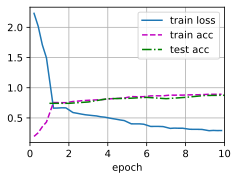

train loss 0.293, train acc 0.891, test acc 0.875


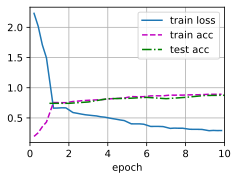

In [11]:
test(train_iter, test_iter, scheduler)